## track trajectory segment generation

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from rdp import rdp
import simplekml
import geopandas as gpd
warnings.filterwarnings('ignore')
from numpy import pi, cos, sin, sqrt, diag
from numpy.linalg import inv
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip

from geopy.distance import great_circle

In [3]:
ll_raw = pd.read_csv('../data/trajectory/Highway Loop Left Lane 11-4-2022 (time stamps).csv')
rl_raw = pd.read_csv('../data/trajectory/Highway Loop Left Lane 11-4-2022 (time stamps).csv')

ll_raw.shape, rl_raw.shape

((70817, 25), (70817, 25))

In [4]:
ll_raw.columns

Index(['Time from start of file (s)', 'Latitude (deg)', 'Longitude (deg)',
       'Altitude (m)', 'Distance horizontal (m)', 'Velocity forward (m/s)',
       'Velocity lateral (m/s)', 'Velocity down (m/s)',
       'Speed horizontal (m/s)', 'Heading (deg)', 'Pitch (deg)', 'Roll (deg)',
       'Slip angle (deg)', 'Angular rate forward (deg/s)',
       'Angular rate lateral (deg/s)', 'Angular rate down (deg/s)',
       'Angular rate Xv (deg/s)', 'Angular rate Yv (deg/s)',
       'Angular rate Zv (deg/s)', 'Acceleration forward (m/s²)',
       'Acceleration lateral (m/s²)', 'Acceleration down (m/s²)',
       'Acceleration Xv (m/s²)', 'Acceleration Yv (m/s²)',
       'Acceleration Zv (m/s²)'],
      dtype='object')

### Ground Truth Generation
- generate 1k ground truth segments from the surveyed test track (center lane)
- each ground truth segments is around 200m in length, with 100*standard normal distribution
- coordinates are normalized to 0-1
- no noise and sub-sampling are performed at this step

In [4]:
coln_to_keep  = [
    'Latitude (deg)', 'Longitude (deg)', # GPS
    'Velocity lateral (m/s)', 'Velocity forward (m/s)', # speed
    'Heading (deg)', 'Pitch (deg)', 'Roll (deg)', # IMU measurements
    'Angular rate Xv (deg/s)', 'Angular rate Yv (deg/s)',
    'Acceleration Xv (m/s²)', 'Acceleration Yv (m/s²)',
]

ll = ll_raw[coln_to_keep]
rl = rl_raw[coln_to_keep]

ll.rename(columns={
    'Latitude (deg)': 'y', 'Longitude (deg)': 'x',
    'Velocity lateral (m/s)': 'Vy', 'Velocity forward (m/s)': 'Vx',
    'Heading (deg)': 'theta', 'Pitch (deg)': 'psi', 'Roll (deg)': 'phi',
    'Angular rate Xv (deg/s)': 'omega_Xv', 'Angular rate Yv (deg/s)': 'omega_Yv',
    'Acceleration Xv (m/s²)': 'alpha_Xv', 'Acceleration Yv (m/s²)': 'alpha_Yv'
}, inplace=True
)

rl.rename(columns={
    'Latitude (deg)': 'y', 'Longitude (deg)': 'x',
    'Velocity lateral (m/s)': 'Vy', 'Velocity forward (m/s)': 'Vx',
    'Heading (deg)': 'theta', 'Pitch (deg)': 'psi', 'Roll (deg)': 'phi',
    'Angular rate Xv (deg/s)': 'omega_Xv', 'Angular rate Yv (deg/s)': 'omega_Yv',
    'Acceleration Xv (m/s²)': 'alpha_Xv', 'Acceleration Yv (m/s²)': 'alpha_Yv'
}, inplace=True
)

ll.head()

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv
0,42.238643,-83.557448,0.0,0.01,82.408,0.538,0.155,-0.17,-0.87,0.110,-0.005
1,42.238643,-83.557448,0.0,0.01,82.404,0.540,0.154,-0.04,0.18,0.054,-0.080
2,42.238643,-83.557448,0.0,0.01,82.404,0.546,0.154,-0.03,0.56,0.054,-0.041
3,42.238643,-83.557448,0.0,0.01,82.404,0.553,0.154,0.02,0.71,0.132,0.017
4,42.238643,-83.557448,0.0,0.01,82.410,0.547,0.153,-0.14,-0.55,0.118,-0.009


In [5]:
# normalize GPS trajectory

ll_y_max = max(ll['y'])
ll_x_max = max(ll['x'])

ll_y_min = min(ll['y'])
ll_x_min = min(ll['x'])

rl_y_max = max(rl['y'])
rl_x_max = max(rl['x'])

rl_y_min = min(rl['y'])
rl_x_min = min(rl['x'])

ll['y_norm'] = (ll['y'] - ll_y_min) / (ll_y_max - ll_y_min)
ll['x_norm'] = (ll['x'] - ll_x_min) / (ll_x_max - ll_x_min)

rl['y_norm'] = (rl['y'] - rl_y_min) / (rl_y_max - rl_y_min)
rl['x_norm'] = (rl['x'] - rl_x_min) / (rl_x_max - rl_x_min)

# rl = gpd.GeoDataFrame(rl, geometry=gpd.points_from_xy(rl.x, rl.y), crs='EPSG:4326')
# ll = ll.to_crs('EPSG:3857')
# rl = rl.to_crs('EPSG:3857')

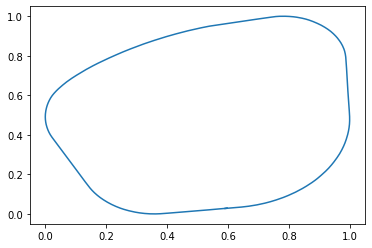

In [8]:
plt.plot(rl.x_norm, rl.y_norm)

In [6]:
# lane encoding
# 0: left lane
# 1: right lane

ll['lane'] = 0
rl['lane'] = 1

ll.head(5)

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,lane
0,42.238643,-83.557448,0.0,0.01,82.408,0.538,0.155,-0.17,-0.87,0.110,-0.005,0.027603,0.590729,0
1,42.238643,-83.557448,0.0,0.01,82.404,0.540,0.154,-0.04,0.18,0.054,-0.080,0.027603,0.590729,0
2,42.238643,-83.557448,0.0,0.01,82.404,0.546,0.154,-0.03,0.56,0.054,-0.041,0.027603,0.590729,0
3,42.238643,-83.557448,0.0,0.01,82.404,0.553,0.154,0.02,0.71,0.132,0.017,0.027603,0.590729,0
4,42.238643,-83.557448,0.0,0.01,82.410,0.547,0.153,-0.14,-0.55,0.118,-0.009,0.027603,0.590730,0


In [10]:
ll.describe().round(3)

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,lane
count,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.0
mean,42.243,-83.558,-0.002,5.232,183.517,0.935,-1.102,0.007,0.015,0.164,0.141,0.492,0.536,0.0
std,0.004,0.005,0.019,0.620,104.608,1.141,0.837,0.556,0.649,0.259,0.181,0.360,0.344,0.0
min,42.238,-83.566,-0.100,0.010,0.001,-1.657,-3.367,-5.170,-5.980,-2.033,-1.926,0.000,0.000,0.0
25%,42.239,-83.563,-0.010,4.870,83.286,0.335,-1.719,-0.320,-0.390,-0.005,0.024,0.105,0.207,0.0
50%,42.243,-83.558,0.000,5.230,190.418,0.690,-0.988,0.010,0.010,0.138,0.132,0.508,0.552,0.0
75%,42.247,-83.553,0.010,5.680,258.478,1.768,-0.566,0.330,0.410,0.346,0.251,0.852,0.879,0.0
max,42.248,-83.551,0.070,6.500,359.996,3.521,1.574,6.460,6.970,2.193,1.762,1.000,1.000,0.0


In [7]:
def seg_generation(traj_truth_df, seg_size, seg_size_sig, num_samples=500):
    
    np.random.seed(0)
    seg_gt = []

    for x in np.random.randint(traj_truth_df.shape[0]-seg_size, size=num_samples):
        seg_size += round(seg_size_sig * randn())
        # seg_sample.append(traj_truth_df[x:x+seg_size, :])
        seg_gt.append(traj_truth_df.iloc[x:x+seg_size])

    return seg_gt

In [41]:
tot_dist = ll_raw.iloc[-1]['Distance horizontal (m)']
seg_dist = 200 # [m]
seg_size = round(seg_dist / (tot_dist / ll.shape[0])) # convert to the length of sample
seg_size_sig = 0 # 100 # length variance

# save all columns
ll_seg_gt = seg_generation(ll, seg_size, seg_size_sig)
rl_seg_gt = seg_generation(rl, seg_size, seg_size_sig)

# save only GPS coordinate columns
gps_colns = ['y', 'x', 'y_norm', 'x_norm']
ll_seg_gps_gt = seg_generation(ll[gps_colns], seg_size, seg_size_sig)
rl_seg_gps_gt = seg_generation(rl[gps_colns], seg_size, seg_size_sig)

In [42]:
# runtime ~= 1.5min

with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_gt, f)
with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_gt, f)

with gzip.open('../data/segment_groud_truth/ll_seg_gps_gt_500.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_gps_gt, f)
with gzip.open('../data/segment_groud_truth/rl_seg_gps_gt_500.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_gps_gt, f)

In [43]:
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gt = pickle.load(f)

print(len(ll_seg_gt))
print(ll_seg_gt[0].shape[0])
ll_seg_gt[0].head()

500
3822


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,lane
43567,42.246179,-83.563086,0.03,5.06,237.273,0.538,-1.124,0.26,-0.65,0.114,0.264,0.786530,0.206384,0
43568,42.246179,-83.563087,0.04,5.06,237.270,0.531,-1.120,0.38,-0.65,-0.068,0.324,0.786505,0.206349,0
43569,42.246179,-83.563087,0.04,5.05,237.261,0.541,-1.115,0.55,1.01,-0.057,0.244,0.786480,0.206314,0
43570,42.246178,-83.563088,0.04,5.05,237.262,0.546,-1.110,0.47,0.43,-0.082,0.268,0.786456,0.206278,0
43571,42.246178,-83.563088,0.04,5.05,237.261,0.539,-1.106,0.45,-0.63,0.063,0.069,0.786431,0.206244,0


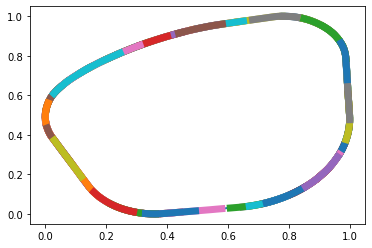

In [54]:
# visualize the generated segments on the test track

plt.plot(ll.x_norm, ll.y_norm)

for i in np.arange(100):

    plt.plot(ll_seg_gt[i].x_norm, ll_seg_gt[i].y_norm, linewidth=7, label='sample segment 1')
# plt.plot(ll_seg_gt[100].x_norm, ll_seg_gt[100].y_norm, linewidth=7, label='sample segment 2')

### Measurement Noise Generation

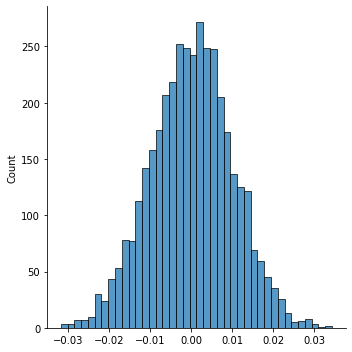

In [12]:
sns.displot(0.01 * randn(*ll_seg_gt[0]['x'].shape))

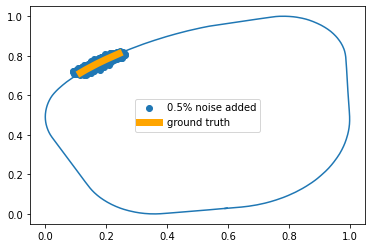

In [47]:
plt.plot(ll.x_norm, ll.y_norm)
plt.scatter(ll_seg_gps_gt[1].x_norm + 0.01 * randn(*ll_seg_gps_gt[1]['x'].shape), ll_seg_gps_gt[1].y_norm + 0.005 * randn(*ll_seg_gps_gt[1]['y'].shape), label='0.5% noise added')
plt.plot(ll_seg_gps_gt[1].x_norm, ll_seg_gps_gt[1].y_norm, linewidth=7, label='ground truth', color='orange')
plt.legend()

In [60]:
def add_gps_noise_downsample(seg_samples, sampling_rate, noise_perc):
    """
    seg_samples: list of df, ll_seg_samples
    sampling_rate: unit [hz]
    noise_perc: 0-1, fraction
    """

    np.random.seed(0)
    # known: the sample rate of the RTK-GPS unit is 250hz
    rtk_sampling_rate = 250
    sampling_spacing = round(rtk_sampling_rate / sampling_rate)
    seg_samples_gps = []

    for seg_sample in seg_samples:
        seg_sample = seg_sample.iloc[::sampling_spacing]
        seg_sample['y_norm_noise'] = seg_sample['y_norm'] + noise_perc * randn(*seg_sample['y_norm'].shape)
        seg_sample['x_norm_noise'] = seg_sample['x_norm'] + noise_perc * randn(*seg_sample['x_norm'].shape)
        seg_samples_gps.append(seg_sample)

    return seg_samples_gps

<AxesSubplot:ylabel='Count'>

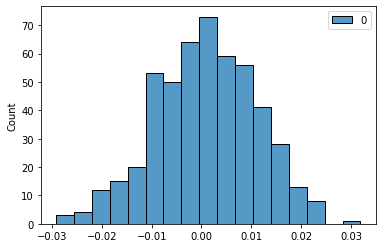

In [30]:
sns.histplot(0.01 * randn(500, 1))

In [61]:
# downsample from 250hz to 1hz, adding 1% spatial noise

ll_seg_gps_noise = add_gps_noise_downsample(ll_seg_gps_gt, 5, 0.005)
rl_seg_gps_noise = add_gps_noise_downsample(rl_seg_gps_gt, 5, 0.005)

ll_seg_noise = add_gps_noise_downsample(ll_seg_gt, 5, 0.005)
rl_seg_noise = add_gps_noise_downsample(rl_seg_gt, 5, 0.005)

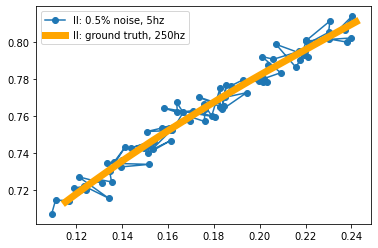

In [62]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.plot(ll_seg_gps_noise[1].x_norm_noise, ll_seg_gps_noise[1].y_norm_noise, '-o', label='ll: 0.5% noise, 5hz')
plt.plot(ll_seg_gt[1].x_norm, ll_seg_gt[1].y_norm, linewidth=7, label='ll: ground truth, 250hz', color='orange')

plt.legend()

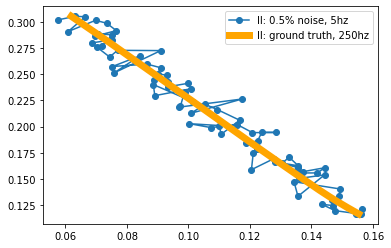

In [63]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.plot(ll_seg_gps_noise[200].x_norm_noise, ll_seg_gps_noise[200].y_norm_noise, '-o', label='ll: 0.5% noise, 5hz')
plt.plot(ll_seg_gt[200].x_norm, ll_seg_gt[200].y_norm, linewidth=7, label='ll: ground truth, 250hz', color='orange')

plt.legend()

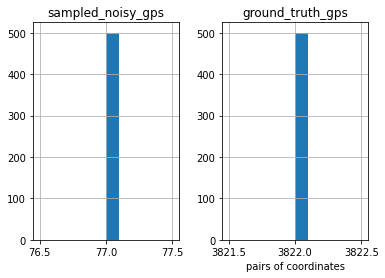

In [51]:
x_count = []
y_count = []

for x_seg in ll_seg_gps_noise:
    x_count.append(len(x_seg))
for y_seg in ll_seg_gt:
    y_count.append(len(y_seg))

graph_df = pd.DataFrame() 

graph_df['sampled_noisy_gps'] = x_count
graph_df['ground_truth_gps'] = y_count

graph_df.hist(bins = 10)
plt.xlabel('pairs of coordinates')
plt.show()

In [64]:
# save as pickle objects

with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_noise, f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_noise, f)

with gzip.open('../data/segment_with_noise/ll_seg_gps_500_noise.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_gps_noise, f)
with gzip.open('../data/segment_with_noise/rl_seg_gps_500_noise.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_gps_noise, f)